In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import pandas as pd

df = pd.read_csv('log_tcp_complete_classes.txt', sep = " ")

N. flows =  100000
N. classes =  10
['class:google' 'class:bing' 'class:linkedin' 'class:instagram'
 'class:youtube' 'class:netflix' 'class:spotify' 'class:facebook'
 'class:ebay' 'class:amazon']


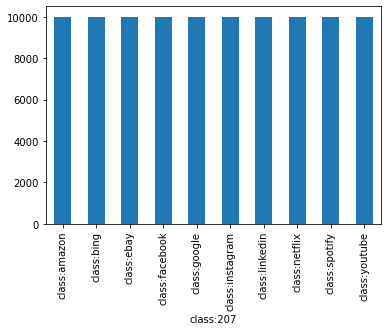

In [2]:
n_flows = len(df)
classes = df['class:207'].unique()
n_classes = len(classes)

print("N. flows = ", n_flows)
print("N. classes = ", n_classes)
print(classes)

a = df.groupby(['class:207']).size().sort_values(ascending=False).plot(kind='bar')

## Task 2: data cleaning

In [ ]:
df = df.drop(labels=[''], axis=1)

## Task 3: data splitting

In [4]:
# sempre fit su train, sempre transform su entrambi
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['class:207'], axis=1), df['class:207'], test_size=0.33, random_state=0)
print("Training test size: ", len(df_train), "\nTest set size: ", len(df_test))
df_test

Training test size:  67000 
Test set size:  33000


,#31#c_ip:1,c_port:2,c_pkts_all:3,c_rst_cnt:4,c_ack_cnt:5,c_ack_cnt_p:6,c_bytes_uniq:7,c_pkts_data:8,c_bytes_all:9,c_pkts_retx:10,...,s_pkts_data_std:198,c_seg_cnt:199,c_sit_avg:200,c_sit_std:201,s_seg_cnt:202,s_sit_avg:203,s_sit_std:204,c_pkts_push:205,s_pkts_push:206,class:207
3582,156.60.242.229,33300,19,0,18,9,2406,9,2406,0,...,612.356471,9,79.696125,126.654013,12,44.602818,66.392253,8,10,class:google
60498,246.216.209.61,58222,21,0,20,11,1550,8,2051,1,...,633.566483,8,634.471000,1280.481847,14,2649.526692,8256.647428,6,6,class:spotify
53227,156.60.241.68,64252,13,0,12,7,4382,5,4382,0,...,704.964977,5,153.241500,168.652006,7,10236.235333,24492.845313,3,4,class:netflix
21333,254.211.188.44,56172,5,0,4,2,636,1,636,0,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,1,1,class:linkedin
3885,180.102.5.88,54173,19,0,18,9,2161,9,2161,0,...,619.014055,9,47.493250,67.953726,11,30.599600,59.398826,8,9,class:google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95945,246.30.227.109,53943,3,0,2,1,0,0,0,0,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,class:amazon
23711,246.30.241.143,60355,15,0,14,7,1586,7,1586,0,...,634.937980,7,3754.142500,9135.677127,7,3772.974833,9128.162548,7,5,class:linkedin
71276,156.60.243.199,59560,13,0,12,6,5136,6,5136,0,...,253.381418,6,23.458200,9.271245,7,85.256833,113.633359,3,7,class:facebook
40809,246.25.63.48,56614,15,0,14,8,2754,6,3447,1,...,488.908210,6,5094.602400,10044.825683,7,4249.209667,9247.518269,6,5,class:youtube


## Task 4: data preprocessing